In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.sparse import csr_matrix
import subprocess
import numpy as np
from Bio import SeqIO

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, RMSprop
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, LSTM, SimpleRNN, GRU

from sklearn.metrics import confusion_matrix
import itertools

In [3]:
intr_file = '../ubuntu/data/hg19_intr_clean.fa'
depl_file = '../ubuntu/data/hg19_depl_clean.fa'

e = 0
intr_seqs = []
depl_seqs = []
for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):
    
    step = 200; jump = 1; a = 0; b = step; n_jumps = 5
    for j in range(n_jumps):
        s_intr = str(intr.seq)[a:b]
        s_depl = str(depl.seq)[a:b]
        intr_seqs.append(s_intr)
        depl_seqs.append(s_depl)
        a = a + jump
        b = a + step
    
    e = e + 1
    if e%20000 == 0:
        print('Finished ' + str(e) + ' entries')
        
def getKmers(sequence, size):
    return [sequence[x:x+size].upper() for x in range(len(sequence) - size + 1)]

Finished 20000 entries
Finished 40000 entries
Finished 60000 entries


In [4]:
kmer = [7]
for k in kmer:
    print('KMER: ', k)
    intr_texts = [' '.join(getKmers(i, k)) for i in intr_seqs]
    depl_texts = [' '.join(getKmers(i, k)) for i in depl_seqs]

    merge_texts = intr_texts + depl_texts

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(merge_texts)
    #X = tokenizer.texts_to_matrix(merge_texts, mode = 'freq')

    encoded_docs = tokenizer.texts_to_sequences(merge_texts)
    max_length = max([len(s.split()) for s in merge_texts])
    X = pad_sequences(encoded_docs, maxlen = max_length, padding = 'post')

    l_intr = len(intr_texts)
    l_depl = len(depl_texts)
    vocab_size = len(tokenizer.word_index) + 1

    X_intr = X[0:l_intr]
    X_depl = X[l_intr:]

    adj_intr0 = np.zeros(
        shape = (vocab_size,vocab_size))
    for s in X_intr:
        for i in range(len(s)-1):
            j = int(s[i])
            k = int(s[i+1])
            adj_intr0[j,k] += 1
    adj_depl0 = np.zeros(
        shape = (vocab_size,vocab_size))
    for s in X_depl:
        for i in range(len(s)-1):
            j = int(s[i])
            k = int(s[i+1])
            adj_depl0[j,k] += 1
    
    adj_depl0 /= len(X_depl)
    adj_intr0 /= len(X_intr)
    diff_matrix = np.abs(np.subtract(adj_intr0, adj_depl0))
    diff_node_degree = np.sum(diff_matrix)
    print('DIFFERENCE GRADE: ', diff_node_degree)

KMER:  7
DIFFERENCE GRADE:  31.905283245188578


In [5]:
adj_intr = np.copy(adj_intr0[1:,1:])
adj_depl = np.copy(adj_depl0[1:,1:])

In [6]:
q = adj_intr[0] 
q[q != 0]

array([0.322815  , 0.03849299, 0.036751  , 0.04000327])

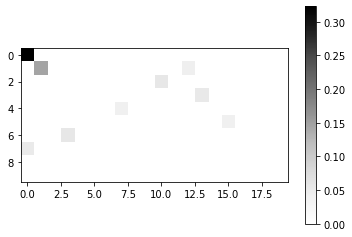

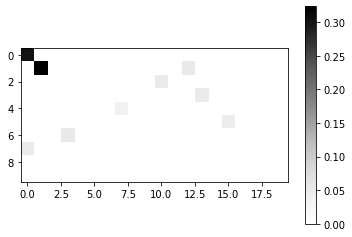

In [7]:
plt.imshow(adj_intr[0:10,0:20], cmap = 'Greys')
plt.colorbar()
plt.show()
plt.imshow(adj_depl[0:10, 0:20], cmap = 'Greys')
plt.colorbar()
plt.show()

In [8]:
for row in range(len(adj_intr)):
    s = sum(adj_intr[row])
    if(s == 0.0):
        continue
    adj_intr[row] = np.array([i/s for i in adj_intr[row]])
    
for row in range(len(adj_depl)):
    s = sum(adj_depl[row])
    if(s == 0.0):
        continue
    adj_depl[row] = np.array([i/s for i in adj_depl[row]])

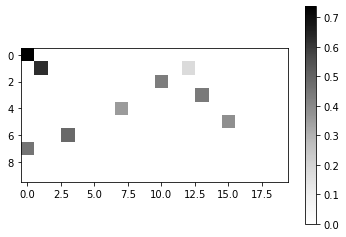

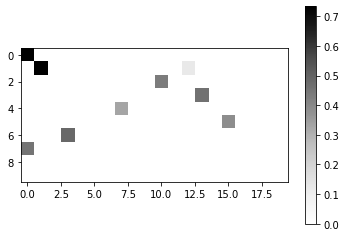

In [9]:
plt.imshow(adj_intr[0:10,0:20], cmap = 'Greys')
plt.colorbar()
plt.show()
plt.imshow(adj_depl[0:10, 0:20], cmap = 'Greys')
plt.colorbar()
plt.show()

In [10]:
q = adj_intr[0] 
np.where(q!=0)

(array([ 0, 30, 43, 50]),)

In [11]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

In [12]:
reverse_word_map

{1: 'ttttttt',
 2: 'aaaaaaa',
 3: 'tttattt',
 4: 'tttaaaa',
 5: 'tattttt',
 6: 'aaaaata',
 7: 'ttttaaa',
 8: 'atttttt',
 9: 'aaataaa',
 10: 'tttcttt',
 11: 'ttatttt',
 12: 'aaagaaa',
 13: 'aaaaaat',
 14: 'ttaaaaa',
 15: 'tttttaa',
 16: 'aaaataa',
 17: 'ttttctt',
 18: 'aagaaaa',
 19: 'ttttatt',
 20: 'tgtgtgt',
 21: 'taaaaat',
 22: 'attttta',
 23: 'tttttct',
 24: 'ttctttt',
 25: 'aattttt',
 26: 'aataaaa',
 27: 'aaaaatt',
 28: 'agaaaaa',
 29: 'acacaca',
 30: 'tttgttt',
 31: 'tttttta',
 32: 'aaaagaa',
 33: 'atatata',
 34: 'tatatat',
 35: 'gtgtgtg',
 36: 'taatttt',
 37: 'aaaatta',
 38: 'taaaaaa',
 39: 'ctttttt',
 40: 'atatttt',
 41: 'aaaatat',
 42: 'atttatt',
 43: 'tcttttt',
 44: 'ttttttg',
 45: 'aaacaaa',
 46: 'acaaaaa',
 47: 'tttttat',
 48: 'tttttgt',
 49: 'ttgtttt',
 50: 'cacacac',
 51: 'ttttttc',
 52: 'aaaaaga',
 53: 'aaatatt',
 54: 'aatattt',
 55: 'aataaat',
 56: 'ataaaaa',
 57: 'aaaacaa',
 58: 'ttaaaat',
 59: 'ttttgtt',
 60: 'tatttta',
 61: 'aaaaaag',
 62: 'caaaaaa',
 63: 'attttat',
 

In [14]:
n = 50000000
burn_in = 5000
Introgressed = np.zeros(shape = (n+burn_in))
Depleted = np.zeros(shape = (n+burn_in))
#pos0 = np.random.randint(len(adj_intr))
pos0 = 0
Introgressed[0] = pos0
for i in range(1,n+burn_in):
    pos = int(Introgressed[i-1])
    l = adj_intr[pos]
    p = np.random.random()
    possibilities = np.where(l!=0)
    possibilities = possibilities[0]
    q = np.cumsum(l[possibilities])
    val = q-p
    val[val <= 0] = 1
    idx = possibilities[np.argmin(val)]
    Introgressed[i] = int(idx)
Introgressed = Introgressed[burn_in:]

In [15]:
print([i for i in Introgressed[0:10]])
print([reverse_word_map[i+1] for i in Introgressed[0:10]])

[7207.0, 910.0, 5875.0, 5996.0, 3711.0, 842.0, 1111.0, 3123.0, 3611.0, 1895.0]
['gatgcaa', 'atgcaaa', 'tgcaaac', 'gcaaact', 'caaactg', 'aaactga', 'aactgaa', 'actgaag', 'ctgaagg', 'tgaagga']


In [16]:
#pos0 = np.random.randint(len(adj_depl))
pos0 = 0
Depleted[0] = pos0
for i in range(1,n+burn_in):
    pos = int(Depleted[i-1])
    l = adj_depl[pos]
    p = np.random.random()
    possibilities = np.where(l!=0)
    possibilities = possibilities[0]
    q = np.cumsum(l[possibilities])
    val = q-p
    val[val <= 0] = 1
    idx = possibilities[np.argmin(val)]
    Depleted[i] = int(idx)
Depleted = Depleted[burn_in:]

In [17]:
print([i for i in Depleted[0:10]])
print([reverse_word_map[i+1] for i in Depleted[0:10]])

[7106.0, 7721.0, 7148.0, 3585.0, 7620.0, 3185.0, 4297.0, 4506.0, 1613.0, 1552.0]
['tggcatc', 'ggcatca', 'gcatcat', 'catcatc', 'atcatcc', 'tcatcct', 'catcctc', 'atcctct', 'tcctctc', 'cctctcc']


In [18]:
print(Depleted[0:10])
Introgressed = Introgressed +1
Depleted = Depleted+1
print(Depleted[0:10])

[7106. 7721. 7148. 3585. 7620. 3185. 4297. 4506. 1613. 1552.]
[7107. 7722. 7149. 3586. 7621. 3186. 4298. 4507. 1614. 1553.]


In [19]:
I_seq = []
D_seq = []
ls = len(X_intr[0])
ns = int(len(Introgressed)/ls)
print(ns)
for i in range(ns):
    I_seq.append(Introgressed[i:(i+1)*ls])
    D_seq.append(Depleted[i:(i+1)*ls])

257731


In [20]:
X_art = I_seq + D_seq
print(len(X_art))
labels = list(np.ones(len(I_seq))) + list(np.zeros(len(D_seq)))

515462


In [50]:
#model = tf.keras.models.load_model('graph_7k')

In [51]:
#print(model.summary())

In [21]:
X_art = pad_sequences(X_art, maxlen = ls, padding = 'post')

### Train with artificial, Test on real

In [22]:
labels = list(np.ones(len(I_seq))) + list(np.zeros(len(D_seq)))
d = 10
print(len(X_art))
print(len(labels))
X_train, X_test, y_train, y_test = train_test_split(X_art, labels, test_size = 0.20, random_state = 42)

y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

max_length = max([len(s.split()) for s in merge_texts])

vocab_size = len(tokenizer.word_index) + 1


from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, LSTM, SimpleRNN, GRU, Bidirectional

model = Sequential()
model.add(Embedding(vocab_size, d)) #dropout = 0.2 #input_length = max_length


model.add(Bidirectional(LSTM(int(d/2)))) #dropout = 0.2, recurrent_dropout = 0.2
model.add(Dense(d, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

epochs = 5
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
#checkpoint = ModelCheckpoint("weights.best.hdf5", monitor = 'val_acc', verbose = 1, 
#                             save_best_only = True, mode = 'max')

print(model.summary())

history = model.fit(X_train, y_train, 
                    epochs = epochs, verbose = 2, validation_split = 0.2, batch_size = 32, shuffle = True, 
#                    callbacks = [checkpoint]
                   )

predicted_labels = model.predict(X_test)
cm = confusion_matrix(y_test, [np.round(i[0]) for i in predicted_labels])
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

scores = model.evaluate(X_test, y_test, verbose = 0)
print("Accuracy: %.2f%%" % (scores[1]*100))

515462
515462
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 10)          163850    
_________________________________________________________________
bidirectional (Bidirectional (None, 10)                640       
_________________________________________________________________
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 164,611
Trainable params: 164,611
Non-trainable params: 0
_________________________________________________________________
None
Train on 329895 samples, validate on 82474 samples
Epoch 1/5
329895/329895 - 383s - loss: 0.5666 - accuracy: 0.7025 - val_loss: 0.5215 - val_accuracy: 0.7460
Epoch 2/5
329895/329895 - 366s - loss: 0.5054 - accuracy: 0.7556 - val_

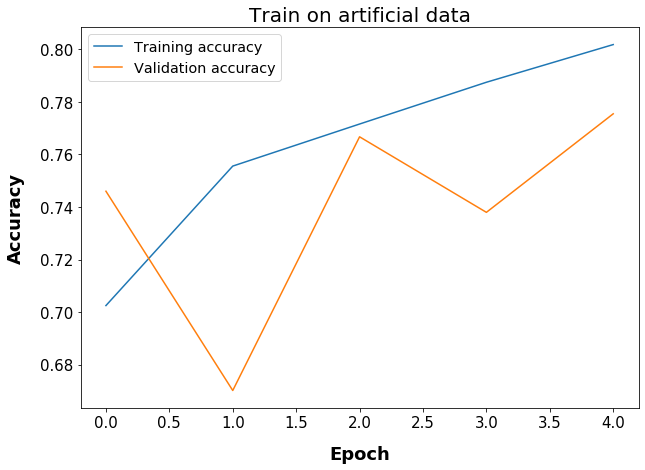

In [23]:
plt.figure(figsize = (10,7))
plt.plot(history.history['accuracy'], label = 'Training accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation accuracy')
plt.title('Train on artificial data', fontsize = 20, weight = 'roman')
plt.xlabel('Epoch', fontsize = 18, labelpad = 15, weight = 'semibold')
plt.ylabel('Accuracy', fontsize = 18, labelpad = 15, weight = 'semibold')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 'x-large')
plt.show()

In [24]:
predicted_labels = model.predict(X)
labels = list(np.ones(len(intr_texts))) + list(np.zeros(len(depl_texts)))
predicted_labels = np.around(predicted_labels)
print(predicted_labels)
cm = confusion_matrix(labels, [np.round(i[0]) for i in predicted_labels])
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
print(cm)

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
[[0.31011668 0.68988332]
 [0.11538629 0.88461371]]


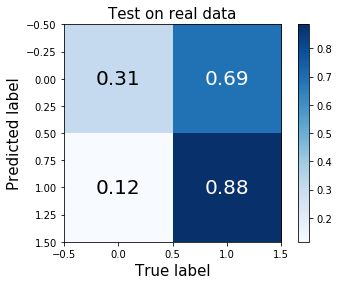

In [25]:
plt.imshow(cm, cmap = plt.cm.Blues)
plt.title('Test on real data', fontsize = 15)
plt.colorbar()
plt.xlabel('True label', fontsize = 15)
plt.ylabel('Predicted label', fontsize = 15)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment = 'center', verticalalignment = 'center', fontsize = 20,
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()

In [1]:
!nvidia-smi

Sun Jun  7 12:19:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.64       Driver Version: 430.64       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   39C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  